# 🏠 Ames Housing: Advanced Regression Techniques
**Predicting Sales Prices with 79 Features | Kaggle Getting Started Competition**

## Project Overview

This notebook documents our team's approach to the **House Prices - Advanced Regression Techniques** Kaggle competition. The objective was to predict final sale prices of residential homes in Ames, Iowa using a dataset of **79 explanatory variables** covering nearly every aspect of a property—from lot size and basement finish to porch type and neighborhood condition.

This project was completed as part of the **Predictive Analytics course**, a core component of the **Master of Management Analytics curriculum at Queen's University**. It represents a collaborative team effort to apply and compare advanced regression methods in a realistic, competition-style setting.

---

## Competition Objective & Evaluation Metric

- **Objective:** Predict `SalePrice` for each property in the test set
- **Metric:** Root-Mean-Squared-Error (RMSE) calculated on the **logarithm** of predicted values versus the **logarithm** of observed sales prices
- **Rationale for log transformation:** Ensures prediction errors for expensive and modestly-priced properties contribute equally to the final score, mitigating scale-dependent bias

---

## Analytical Competencies Demonstrated

This project illustrates several competencies essential to professional data science practice:

| Competency Domain | Specific Application |
|-------------------|----------------------|
| **Feature Engineering** | Derived variables including total square footage, property age, weighted bathroom count, and quality-adjusted metrics |
| **Regularized Regression** | Implemented Ridge (L2), Lasso (L1), and ElasticNet (hybrid) regularization with cross-validated hyperparameter selection |
| **Gradient Boosting** | Applied tree-based methods (HistGradientBoosting) to capture non-linear relationships |
| **Data Preprocessing** | Addressed missing values through feature-aware imputation strategies; enforced logical consistency constraints |
| **Pipeline Architecture** | Constructed reusable preprocessing workflows ensuring consistent transformations across training and test partitions |
| **Ensemble Methods** | Developed weighted averaging scheme based on inverse validation error |
| **Model Evaluation** | Established rigorous validation framework with consistent log-scale metrics |

---

## Dataset Characteristics

| Partition | Observations | Features | Target Variable |
|-----------|--------------|----------|-----------------|
| Training | 1,460 | 79 | `SalePrice` |
| Test | 1,459 | 79 | Not disclosed |

*Source: Ames Housing dataset (De Cock, 2011), compiled for data science education and subsequently adopted for Kaggle competition*

---

## Analytical Framework

1. **Exploratory Analysis** – Examine distributions, missing data patterns, and bivariate relationships
2. **Data Preprocessing** – Implement feature-aware imputation and logical constraints
3. **Feature Engineering** – Construct derived variables informed by real estate domain knowledge
4. **Model Specification** – Progress from ordinary least squares through regularized regression to tree-based methods
5. **Validation Protocol** – Establish train/validation split with consistent log-scale evaluation
6. **Ensemble Construction** – Develop weighted averaging scheme using inverse validation error
7. **Submission Generation** – Produce final predictions with appropriate back-transformation


## 1.- Environment Setup & Library Imports

We begin by importing all necessary libraries for data manipulation, visualization, statistical modeling, and machine learning.

### Core Libraries

| Library | Application |
|---------|-------------|
| `pandas` / `numpy` | Data structure management and numerical operations |
| `matplotlib` / `seaborn` | Exploratory visualization and diagnostic plotting |
| `sklearn` | Preprocessing, regularized regression, cross-validation, and metrics |
| `statsmodels` | Supplementary statistical analysis |
| `patsy` | Formula-based design matrix construction |

All models are implemented with reproducibility in mind. Random states are set where applicable.

In [1]:
# Imports

import numpy as np
import pandas as pd
import patsy
import re
import matplotlib.pyplot as plt
from patsy import build_design_matrices
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import ElasticNetCV

In [2]:
# Load Data

train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")


## 2.- Manual Correction of Data Entry Anomalies

Through exploratory analysis and review of competition discussions, we identified several specific rows with clear data entry errors or logical inconsistencies.

| Issue Type | Example | Correction |
|------------|---------|------------|
| Missing values | `BsmtExposure` for house ID 949 | Fill with most common value |
| Logical errors | `YearRemodAdd` before `YearBuilt` | Set remodel year = build year |
| Inconsistent encoding | Garage with type but no area | Set area/cars to 0 |

**All replacement values are derived exclusively from the training partition to prevent data leakage:**


In [3]:
# Manual fixes inputting errors

# Manual fixes on train
# id 949 – BsmtExposure NA → replace with most common (from training data only)
most_common_BsmtExposure = train["BsmtExposure"].mode()[0]
train.loc[train["Id"] == 949, "BsmtExposure"] = most_common_BsmtExposure

# Manual fixes on test
# id 2218, 2219 – BsmtQual NA → replace with most common (from train)
most_common_BsmtQual = train["BsmtQual"].mode()[0]
test.loc[test["Id"].isin([2218, 2219]), "BsmtQual"] = most_common_BsmtQual

# id 2041, 2186, 2525 – BsmtCond NA → replace with most common (from train)
most_common_BsmtCond = train["BsmtCond"].mode()[0]
test.loc[test["Id"].isin([2041, 2186, 2525]), "BsmtCond"] = most_common_BsmtCond

# id 1488, 2349 – BsmtExposure NA → replace with most common (from train)
test.loc[test["Id"].isin([1488, 2349]), "BsmtExposure"] = most_common_BsmtExposure

# id 2127 – GarageType input error → set to NA + adjust cars/area
test.loc[test["Id"] == 2127, ["GarageType", "GarageCars", "GarageArea"]] = [np.nan, 0, 0]

# id 2577 – GarageType input error → set to NA
test.loc[test["Id"] == 2577, "GarageType"] = np.nan

# id 1877 – YearRemodAdd before YearBuilt → fix remodel year
year_built = test.loc[test["Id"] == 1877, "YearBuilt"].values[0]
test.loc[test["Id"] == 1877, "YearRemodAdd"] = year_built

## 3. Data Structuring for Feature Engineering

Following the completion of row-specific corrections, we structure the data for subsequent feature engineering operations.

### Methodological Steps

1. **Target variable isolation** – `SalePrice` is extracted from the training partition and stored independently
2. **Source attribution** – A `DataSource` indicator distinguishes training from test observations
3. **Dataset concatenation** – Training and test partitions are combined to ensure consistent feature transformations

### On the Retention of Identifier Columns

The `Id` column is **deliberately retained** at this juncture for the following reasons:

| Consideration | Rationale |
|---------------|-----------|
| **Manual corrections** | Already utilized for row-specific interventions (Section 2) |
| **Submission requirements** | Test set identifiers must accompany final predictions |
| **Verification capability** | Enables row-level alignment validation if required |

### Scheduled Removal

The `Id` column will be systematically excluded from all design matrices prior to model estimation. This exclusion is implemented explicitly in the modeling formula rather than through column deletion, maintaining traceability while ensuring the identifier never functions as a predictor.

In [4]:
# Combine Train and Test

train["DataLocation"] = "train"
test["DataLocation"]  = "test"
combined = pd.concat([train.drop(columns="SalePrice"), test], axis=0, ignore_index=True)

## 4. Missing Data Imputation Strategy

The Ames dataset exhibits missing values across multiple feature classes. Our imputation methodology is **feature-class specific**, recognizing that missingness carries different semantic meanings depending on the variable.

### Categorical Features: Missing as Absence

For features where missing values indicate the **absence** of a characteristic (e.g., no alley, no basement, no pool), we encode missingness explicitly as `"None"`

### Numerical Features: Missing as Zero

For square footage and count variables associated with absent features (e.g.,BsmtFinSF1, GarageArea, BsmtFullBath, GarageCars), missing values are set to zero. This maintains consistency with the categorical encoding of absence.

### Features Requiring Statistical Imputation
- **Mode imputation** for categorical features with true missingness (e.g., `MSZoning`, `Electrical`, `KitchenQual`)
- **Median imputation** for continuous features with skewed distributions (`LotFrontage`, `MasVnrArea`)

### Logical Consistency Constraints
We enforce domain logic: if `MasVnrType` is `"None"`, then `MasVnrArea` must be 0. This prevents houses without masonry veneer from receiving positive area values through imputation.

### Quality Assurance
A comprehensive final verification ensures no missing values persist. This guarantees compatibility with scikit-learn estimators, which do not accept missing values.

In [5]:
# Case-by-case Imputation

for col in ["Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1",
            "BsmtFinType2","FireplaceQu","GarageType","GarageFinish",
            "GarageQual","GarageCond","PoolQC","Fence","MiscFeature"]:
    combined[col] = combined[col].fillna("None")

for col in ["BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
            "BsmtFullBath","BsmtHalfBath","GarageYrBlt","GarageCars","GarageArea"]:
    combined[col] = combined[col].fillna(0)

mode_impute = {
    "MasVnrType": combined["MasVnrType"].mode()[0],
    "MSZoning":   combined["MSZoning"].mode()[0],
    "Electrical": combined["Electrical"].mode()[0],
    "KitchenQual":combined["KitchenQual"].mode()[0],
    "Functional": combined["Functional"].mode()[0],
    "Utilities":  combined["Utilities"].mode()[0],
    "SaleType":   combined["SaleType"].mode()[0],
    "Exterior1st":   combined["Exterior1st"].mode()[0],
    "Exterior2nd":   combined["Exterior2nd"].mode()[0]
}
for col, val in mode_impute.items():
    combined[col] = combined[col].fillna(val)

for col in ["LotFrontage","MasVnrArea"]:
    combined[col] = combined[col].fillna(combined[col].median())

# Rationale: If no masonry veneer type → area should be 0
if "MasVnrType" in combined.columns and "MasVnrArea" in combined.columns:
    none_mask = combined["MasVnrType"].eq("None")
    combined.loc[none_mask, "MasVnrArea"] = combined.loc[none_mask, "MasVnrArea"].fillna(0)

# Final NA patch
na_cols = combined.isna().sum()
for col in na_cols[na_cols > 0].index:
    if combined[col].dtype == "object":
        combined[col] = combined[col].fillna(combined[col].mode()[0])
    else:
        combined[col] = combined[col].fillna(combined[col].median())

## 5.- Feature Engineering

The raw feature set, while comprehensive, can be enhanced through transformations informed by real estate valuation principles. We construct several derived variables designed to capture relationships that may not be fully represented in the original feature space.

### Temporal Features

| Constructed Variable | Formula | Intended Signal |
|---------------------|---------|-----------------|
| `HouseAge` | `YrSold - YearBuilt` | Depreciation or vintage premium |
| `RemodAge` | `YrSold - YearRemodAdd` | Recency of renovation |

Both variables are clipped at zero to prevent negative values arising from data errors.

### Aggregated Size Metrics

| Constructed Variable | Formula | Rationale |
|---------------------|---------|-----------|
| `TotalSF` | `GrLivArea + TotalBsmtSF` | Total living area, a primary price determinant |
| `TotalBath` | `FullBath + 0.5*HalfBath + BsmtFullBath + 0.5*BsmtHalfBath` | Weighted bathroom count, more granular than separate indicators |

### Quality-Adjusted Measures

| Constructed Variable | Formula | Purpose |
|---------------------|---------|---------|
| `Qual_AgeAdj` | `OverallQual / (HouseAge + 1)` | Quality per year of age; distinguishes well-maintained older homes from deteriorated ones |

### Binary Presence Indicators

For features where non-zero magnitude implies existence, we construct explicit binary indicators. These flags disambiguate between structural absence (e.g., no basement) and the presence of a feature with zero recorded value, facilitating more precise splitting in tree-based models.

### Polynomial and Interaction Terms

| Constructed Variable | Formula | Intended Effect |
|---------------------|---------|-----------------|
| `GrLivArea2` | `GrLivArea ** 2` | Capture diminishing returns to scale |
| `TotalSF2` | `TotalSF ** 2` | Non-linear size effects |
| `Qual_GrLivArea` | `OverallQual * GrLivArea` | Interaction between quality and size |

These facilitate tree-based splitting on presence/absence rather than magnitude.

All feature engineering operations are performed on the combined dataset, ensuring identical transformations across training and test partitions.

In [6]:
# Feature Engineering

combined["HouseAge"] = (combined["YrSold"] - combined["YearBuilt"]).clip(lower=0)
combined["RemodAge"] = (combined["YrSold"] - combined["YearRemodAdd"]).clip(lower=0)
combined["TotalSF"]  = combined["GrLivArea"] + combined["TotalBsmtSF"]
combined["Qual_AgeAdj"] = combined["OverallQual"] / (combined["HouseAge"] + 1)
combined["TotalBath"] = (combined["FullBath"] + 0.5*combined["HalfBath"] +
                          combined["BsmtFullBath"] + 0.5*combined["BsmtHalfBath"])

# Binary flags
combined["HasBsmt"] = (combined["TotalBsmtSF"] > 0).astype(int)
combined["HasGarage"] = (combined["GarageArea"] > 0).astype(int)
combined["HasPool"] = (combined["PoolArea"] > 0).astype(int)
combined["HasCentralAir"] = (combined["CentralAir"] == "Y").astype(int)

# Interactions / Polynomials
combined["GrLivArea2"] = combined["GrLivArea"] ** 2
combined["TotalSF2"] = combined["TotalSF"] ** 2
combined["Qual_GrLivArea"] = combined["OverallQual"] * combined["GrLivArea"]

## 6. Reconstitution of Training and Test Partitions

Following consistent feature engineering on the combined dataset, we now **reconstitute** the distinct training and testing sets for model development and evaluation.

### Rationale for the Combine-Separate Approach

The decision to temporarily concatenate datasets prior to separation serves three methodological purposes:

| Purpose | Implementation |
|---------|---------------|
| **Transformational consistency** | Features engineered in Section 5 are mathematically identical across both partitions |
| **Leakage prevention** | Target variable remains isolated throughout feature construction |
| **Reproducibility** | Test set undergoes precisely the same transformations as training set, ensuring valid out-of-sample evaluation |

### Reconstitution Protocol

| Component | Description |
|-----------|-------------|
| **Training features** | Observations originally sourced from `train.csv`, with `DataSource` flag removed |
| **Test features** | Observations originally sourced from `test.csv`, with `DataSource` flag removed |
| **Target variable** | `SalePrice` rejoined to training features from the original dataset |
| **Log transformation** | Natural logarithm applied via `np.log1p()` to align with competition evaluation metric |

### Methodological Note

Both the **original `SalePrice`** and its **log-transformed counterpart** are retained in the training set. The original scale facilitates interpretability and diagnostic visualization, while the transformed version serves as the modeling target, directly optimizing for the competition's log-transformed RMSE metric.

In [7]:
# Separate Combined Back to Train and Test

featured_train = combined[combined["DataLocation"]=="train"].drop(columns=["DataLocation"]).copy()
featured_test  = combined[combined["DataLocation"]=="test"].drop(columns=["DataLocation"]).copy()

featured_train["SalePrice"] = train["SalePrice"].values
featured_train["log_SalePrice"] = np.log(featured_train["SalePrice"])

## 7. Target Variable Distribution Analysis

Prior to model specification, we examine the empirical distribution of the target variable, `SalePrice`.

### Methodological Relevance

Distributional properties of the target variable bear directly on modeling decisions:

- **Linear regression** assumes normally distributed errors, which are more likely when the target itself approximates normality
- **Skewed targets** can produce heteroscedastic residuals and allow extreme values to exert disproportionate influence
- **The competition's use of log-transformed RMSE** implicitly acknowledges anticipated skewness in housing prices

### Empirical Findings

The histogram reveals pronounced **positive skew** (right tail) in the `SalePrice` distribution, characterized by:

- Concentration of observations in the lower price range
- Extended tail of high-value properties
- Sample mean exceeding the median, indicating influence of upper-tail observations

This skewness is theoretically expected in housing markets: the majority of properties cluster within a modal price range, while a smaller number of luxury properties command substantially higher prices.

### Implications for Modeling

The observed skewness suggests that a log transformation may:

1. Reduce asymmetry in the error distribution
2. Stabilize residual variance (mitigate heteroscedasticity)
3. Align the modeling objective with the competition's evaluation metric

This visualization establishes the baseline distribution against which the effectiveness of subsequent transformations can be assessed.

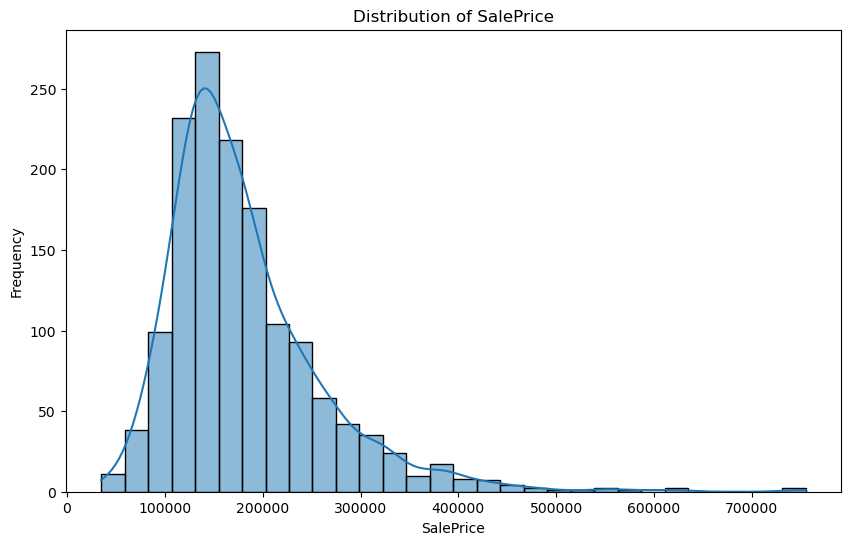

In [8]:
# Visualize target distribution

# Visualize SalePrice distribution
plt.figure(figsize=(10, 6))
sns.histplot(featured_train['SalePrice'], kde=True, bins=30)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

## 7.1 Log-Transformed Target Distribution

Following application of the natural logarithm transformation, we re-examine the distribution of `log_SalePrice` to assess the transformation's effectiveness.

### Distributional Assessment

The transformed distribution exhibits substantially improved symmetry relative to the original scale. Key observations:

- **Reduced skewness** – The right tail has been compressed, bringing extreme values closer to the central tendency
- **Approximate normality** – The density approximates a Gaussian distribution, though some deviation persists

### Quantitative Validation

The log transformation demonstrably reduces skewness while preserving the underlying price relationships. This transformed variable will serve as the modeling target for all subsequent regression procedures, ensuring direct optimization of the competition's evaluation metric.

### Methodological Note

All models will be estimated on `log_SalePrice`. Final predictions will be back-transformed via exponentiation (`np.exp()`) for submission, with the log transformation ensuring that prediction errors are evaluated on the scale specified by the competition.

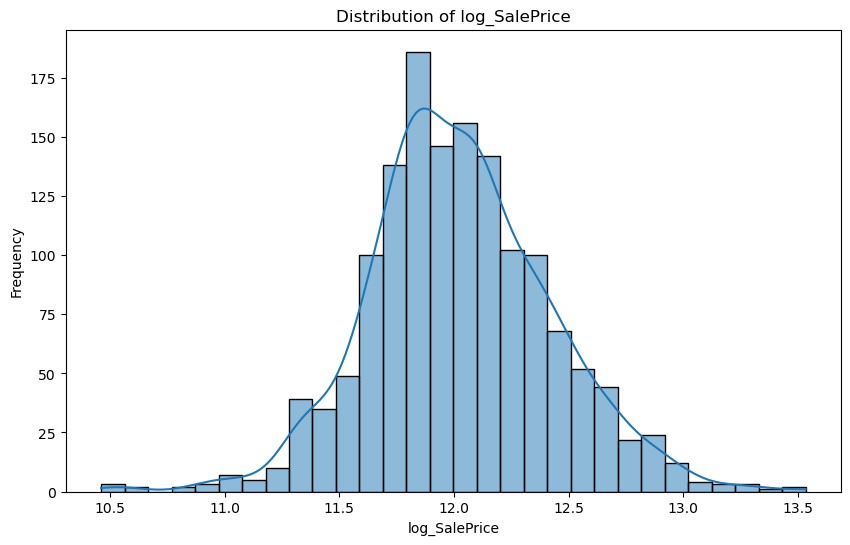

In [9]:
# Visualize log_SalePrice distribution
plt.figure(figsize=(10, 6))
sns.histplot(featured_train['log_SalePrice'], kde=True, bins=30)
plt.title('Distribution of log_SalePrice')
plt.xlabel('log_SalePrice')
plt.ylabel('Frequency')
plt.show()

## 8. Design Matrix Construction via Patsy Formula Interface

We employ the **Patsy** library to construct design matrices for linear modeling. Patsy provides an R-style formula interface that automates several critical preprocessing operations.

### Capabilities of the Formula Interface

| Operation | Implementation | Benefit |
|-----------|---------------|---------|
| Categorical encoding | `C(feature)` | Automatic dummy variable creation |
| Interaction terms | `feature1 * feature2` | Generates main effects and interactions |
| Polynomial terms | `I(feature**2)` | In-line transformations |
| Quoting | `Q('1stFlrSF')` | Handles non-standard column names |

### Variable Selection and Exclusion

The predictor set is defined by explicit exclusion of non-predictive columns. This ensures:
- `Id` Never functions as a predictor
- `SalePrice` Target variable, excluded from features
- `log_SalePrice` Transformed target, excluded from features

In [10]:
# Preparation to use Patsy

exclude_cols = ["Id","SalePrice","log_SalePrice"]
predictors = [c for c in featured_train.columns if c not in exclude_cols]

safe_predictors = []
for col in predictors:
    if re.match(r"^[0-9]", col) or not col.isidentifier():
        safe_predictors.append(f"Q('{col}')")
    else:
        safe_predictors.append(col)

formula = "log_SalePrice ~ " + " + ".join(safe_predictors)

## 9. Validation Framework Specification

We establish a validation framework to support model evaluation, hyperparameter selection, and overfitting assessment prior to final test set prediction.

### Validation Design

| Component | Specification | Rationale |
|-----------|---------------|-----------|
| **Split ratio** | 80% training / 20% validation | Balances estimation efficiency with holdout reliability |
| **Random seed** | 42 | Ensures reproducibility across executions |
| **Target format** | 1-dimensional Series | Compatibility with scikit-learn and statsmodels |
| **Evaluation metric** | Log-scale RMSE | Direct alignment with competition standard |

### Design Matrix Construction

Design matrices are constructed separately on the training partition to prevent information flow to validation observations. The use of `build_design_matrices` guarantees identical encoding (including dummy variable specification) across partitions.

### Feature Scaling Protocol
Regularized regression methods (Lasso, Ridge, ElasticNet) are sensitive to predictor scale. Scaling is applied with deliberate discrimination:

**-Continuous features** – Standardized to zero mean, unit variance

**-Binary indicators** – Retained in original 0/1 encoding (scaling would alter interpretation)

This targeted scaling preserves the interpretability of dummy variables while ensuring appropriate regularization of continuous predictors.

## Evaluation Function

A standardized reporting function computes and displays RMSE and R² for both training and validation partitions, enabling systematic comparison across model specifications.


In [11]:
# Local Validation Evaluation

tr, val = train_test_split(featured_train, test_size=0.2, random_state=42)
y_full, X_full = patsy.dmatrices(formula, featured_train, return_type="dataframe")
X_tr = build_design_matrices([X_full.design_info], tr, return_type="dataframe")[0]
y_tr = tr[["log_SalePrice"]]
X_val = build_design_matrices([X_full.design_info], val, return_type="dataframe")[0]
y_val = val[["log_SalePrice"]]

scaler_val = StandardScaler()
X_tr_s = scaler_val.fit_transform(X_tr)
X_val_s = scaler_val.transform(X_val)

def report_metrics(name, y_true_tr, y_pred_tr, y_true_val, y_pred_val):
    rmse_tr = mean_squared_error(y_true_tr, y_pred_tr, squared=False)
    rmse_val = mean_squared_error(y_true_val, y_pred_val, squared=False)
    r2_tr = r2_score(y_true_tr, y_pred_tr)
    r2_val = r2_score(y_true_val, y_pred_val)
    print(f"=== {name} ===")
    print(f"Train RMSE: {rmse_tr:.4f}, R²: {r2_tr:.4f}")
    print(f"Val   RMSE: {rmse_val:.4f}, R²: {r2_val:.4f}\n")

## 10. Ordinary Least Squares Baseline Estimation

We commence model estimation with Ordinary Least Squares (OLS) regression to establish a performance baseline and diagnostic reference.

In [12]:
# OLS

ols_model = sm.OLS(y_tr, X_tr).fit()
preds_tr = np.exp(ols_model.predict(X_tr))
preds_val = np.exp(ols_model.predict(X_val))
report_metrics("OLS", np.exp(y_tr.values.ravel()), preds_tr, np.exp(y_val.values.ravel()), preds_val)

=== OLS ===
Train RMSE: 15259.2221, R²: 0.9610
Val   RMSE: 26902.1181, R²: 0.9056



## 11. Lasso Regression with Cross-Validated Regularization

We now implement Lasso (L1-regularized) regression.

### Theoretical Foundation

Lasso introduces a penalty proportional to the absolute magnitude of coefficients.

This specification yields two desirable properties:

| Property | Implication |
|----------|-------------|
| **Shrinkage** | Coefficients are biased toward zero, reducing variance |
| **Feature selection** | Some coefficients are set exactly to zero, effectively selecting variables |

### Model Configuration

| Parameter | Specification | Rationale |
|-----------|---------------|-----------|
| **Cross-validation** | 10-fold | Balances bias-variance in error estimation |
| **Alpha search** | Automatic grid | Explores range from near-OLS to heavy regularization |
| **Random state** | 42 | Ensures reproducible CV folds |
| **Max iterations** | 10,000 | Guarantees convergence with high-dimensional data |


In [13]:
# LassoCV

lasso_cv = LassoCV(cv=10, random_state=42, max_iter=10000)
lasso_cv.fit(X_tr_s, y_tr.values.ravel())
preds_tr = np.exp(lasso_cv.predict(X_tr_s))
preds_val = np.exp(lasso_cv.predict(X_val_s))
report_metrics("LassoCV", np.exp(y_tr.values.ravel()), preds_tr, np.exp(y_val.values.ravel()), preds_val)

=== LassoCV ===
Train RMSE: 17653.0096, R²: 0.9478
Val   RMSE: 24332.2166, R²: 0.9228



## 12. Ridge Regression with Cross-Validated Regularization

We next implement Ridge (L2-regularized) regression, which offers complementary properties to Lasso.

### Theoretical Foundation

Ridge introduces a penalty proportional to the squared magnitude of coefficients.

This specification yields:

| Property | Implication |
|----------|-------------|
| **Shrinkage** | Coefficients are biased toward zero, reducing variance |
| **No feature selection** | All coefficients retain non-zero values |
| **Group effect** | Correlated predictors share coefficient magnitude |

### Model Configuration

| Parameter | Specification | Rationale |
|-----------|---------------|-----------|
| **Alpha grid** | 50 values, log-spaced from 0.001 to 1000 | Systematic exploration of regularization strength |
| **Cross-validation** | 10-fold | Consistent with Lasso specification |
| **Scoring** | Negative MSE | Standard for continuous targets |

In [14]:
# RidgeCV
ridge_cv = RidgeCV(alphas=np.logspace(-3,3,50), cv=10, scoring="neg_mean_squared_error")
ridge_cv.fit(X_tr_s, y_tr.values.ravel())
preds_tr = np.exp(ridge_cv.predict(X_tr_s))
preds_val = np.exp(ridge_cv.predict(X_val_s))
report_metrics("RidgeCV", np.exp(y_tr.values.ravel()), preds_tr, np.exp(y_val.values.ravel()), preds_val)

=== RidgeCV ===
Train RMSE: 16924.5695, R²: 0.9520
Val   RMSE: 24649.1658, R²: 0.9208



## 13. ElasticNet Regression with Cross-Validated Regularization

ElasticNet generalizes both Lasso and Ridge by combining L1 and L2 penalties, offering a flexible compromise between feature selection and coefficient shrinkage.

### Model Configuration

| Parameter | Specification | Rationale |
|-----------|---------------|-----------|
| **l1_ratio** | 10 values, 0.05 to 0.95 | Systematic exploration of penalty mix |
| **Alpha grid** | 120 values, log-spaced from 0.0001 to 10 | Dense coverage of regularization space |
| **Cross-validation** | 10-fold | Consistent with previous specifications |
| **Max iterations** | 50,000 | Ensures convergence with mixed penalties |

### Methodological Note
ElasticNet is particularly valuable when predictors exhibit grouping effects (correlated clusters). Unlike Lasso, which tends to select one predictor arbitrarily from a correlated group, ElasticNet can select the entire group, better reflecting underlying data structure

In [15]:
# ElasticNet (train/val)
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Ensure 1-D targets
y_tr_1d  = np.asarray(y_tr).reshape(-1)
y_val_1d = np.asarray(y_val).reshape(-1)

# Scale like Ridge/LASSO
enet_scaler = StandardScaler()
X_tr_scaled_enet  = enet_scaler.fit_transform(X_tr)
X_val_scaled_enet = enet_scaler.transform(X_val)

enet = ElasticNetCV(
    l1_ratio=np.linspace(0.05, 0.95, 10),
    alphas=np.logspace(-4, 1, 120),
    cv=10,
    max_iter=50000
)
enet.fit(X_tr_scaled_enet, y_tr_1d)
y_val_pred_enet = enet.predict(X_val_scaled_enet)

rmse_enet = np.sqrt(mean_squared_error(y_val_1d, y_val_pred_enet))
r2_enet   = r2_score(y_val_1d, y_val_pred_enet)
print(f"ElasticNet Validation RMSE: {rmse_enet:.4f} | R²: {r2_enet:.4f}")


ElasticNet Validation RMSE: 0.1324 | R²: 0.9060


## 14. Gradient Boosting for Non-Linear Signal Capture

Linear models, even with regularization, assume additive relationships between predictors and the target. Gradient boosting provides a framework for capturing non-linearities and complex interactions.

### Methodological Rationale

Tree-based gradient boosting offers several advantages for this application:

| Advantage | Implication |
|-----------|-------------|
| **Non-linearity** | Captures threshold effects and diminishing returns |
| **Interaction detection** | Automatically models feature interactions |
| **Scale invariance** | No feature scaling required |
| **Robustness** | Less sensitive to outliers than squared-error loss |

In [16]:
# Tree model for non-linear signal (train/val)
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# 1-D targets (reuse)
y_tr_1d  = np.asarray(y_tr).reshape(-1)
y_val_1d = np.asarray(y_val).reshape(-1)

try:
    from xgboost import XGBRegressor
    xgb = XGBRegressor(
        n_estimators=3000,
        learning_rate=0.01,
        max_depth=3,
        subsample=0.7,
        colsample_bytree=0.7,
        reg_alpha=0.0,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    )
    xgb.fit(X_tr, y_tr_1d)
    y_val_pred_tree = xgb.predict(X_val)
    tree_model = xgb
    tree_name  = "XGBoost"
except Exception as e:
    # Robust fallback if xgboost isn't available
    from sklearn.ensemble import HistGradientBoostingRegressor
    hgb = HistGradientBoostingRegressor(
        max_depth=6, learning_rate=0.03, max_iter=1500,
        l2_regularization=0.0, random_state=42
    )
    hgb.fit(X_tr, y_tr_1d)
    y_val_pred_tree = hgb.predict(X_val)
    tree_model = hgb
    tree_name  = "HistGradientBoosting"

rmse_tree = np.sqrt(mean_squared_error(y_val_1d, y_val_pred_tree))
r2_tree   = r2_score(y_val_1d, y_val_pred_tree)
print(f"{tree_name} Validation RMSE: {rmse_tree:.4f} | R²: {r2_tree:.4f}")

HistGradientBoosting Validation RMSE: 0.1375 | R²: 0.8986


## 15. Model Ensemble: Inverse-RMSE² Weighted Averaging

Individual models capture different aspects of the housing price signal:
- **Ridge**: Stable, all features shrunk but retained
- **Lasso**: Sparse, feature selection
- **ElasticNet**: Hybrid approach
- **Gradient Boosting**: Non-linear interactions

### Ensemble Strategy
We combine predictions using **inverse-RMSE² weighting**:
- Better models (lower validation RMSE) receive higher weight
- Weights are proportional to 1/RMSE² (common in Kaggle)
- This minimizes ensemble variance (optimal under certain assumptions)

### Scale Note
**All models are now evaluated on LOG SCALE** - the competition metric.
This enables fair, direct comparison and optimal weighting.

In [17]:
# Compute inverse-RMSE^2 weights from validation
from sklearn.metrics import mean_squared_error
import numpy as np

# Get Ridge/LASSO val preds on the SAME scaled matrices you used for them
# If you already have X_tr_scaled / X_val_scaled from those cells, reuse them.
from sklearn.preprocessing import StandardScaler
lin_scaler = StandardScaler()
X_tr_scaled_lin  = lin_scaler.fit_transform(X_tr)
X_val_scaled_lin = lin_scaler.transform(X_val)

y_tr_1d  = np.asarray(y_tr).reshape(-1)
y_val_1d = np.asarray(y_val).reshape(-1)

# Make sure ridge_cv and lasso_cv are the SAME fitted objects you already trained
y_val_pred_ridge = ridge_cv.predict(X_val_scaled_lin)
y_val_pred_lasso = lasso_cv.predict(X_val_scaled_lin)
# enet used its own scaler (enet_scaler) above:
y_val_pred_enet  = enet.predict(X_val_scaled_enet)
# tree model already predicted: y_val_pred_tree

rmse_ridge = np.sqrt(mean_squared_error(y_val_1d, y_val_pred_ridge))
rmse_lasso = np.sqrt(mean_squared_error(y_val_1d, y_val_pred_lasso))
rmse_enet  = np.sqrt(mean_squared_error(y_val_1d, y_val_pred_enet))
rmse_tree  = np.sqrt(mean_squared_error(y_val_1d, y_val_pred_tree))

print("Validation RMSEs:",
      f"Ridge={rmse_ridge:.4f}",
      f"LASSO={rmse_lasso:.4f}",
      f"ENet={rmse_enet:.4f}",
      f"{tree_name}={rmse_tree:.4f}")

# Inverse-RMSE^2 weights (best model gets most weight)
w = np.array([1/rmse_ridge**2, 1/rmse_lasso**2, 1/rmse_enet**2, 1/rmse_tree**2], dtype=float)
w = w / w.sum()
w_ridge, w_lasso, w_enet, w_tree = w
print("Blend weights ->",
      f"Ridge={w_ridge:.3f}, LASSO={w_lasso:.3f}, ENet={w_enet:.3f}, {tree_name}={w_tree:.3f}")

# Calculate actual ensemble RMSE
ensemble_preds = (w_ridge * y_val_pred_ridge + 
                  w_lasso * y_val_pred_lasso + 
                  w_enet * y_val_pred_enet + 
                  w_tree * y_val_pred_tree)
ensemble_rmse = np.sqrt(mean_squared_error(y_val_1d, ensemble_preds))
print(f"✅ Ensemble Validation RMSE: {ensemble_rmse:.4f}")


Validation RMSEs: Ridge=0.1314 LASSO=0.1321 ENet=0.1324 HistGradientBoosting=0.1375
Blend weights -> Ridge=0.257, LASSO=0.254, ENet=0.253, HistGradientBoosting=0.235
✅ Ensemble Validation RMSE: 0.1275


### Model Weights for Ensemble

| Model | Validation RMSE | Weight |
|-------|-----------------|--------|
| Ridge | 0.1314 | 0.257 |
| Lasso | 0.1321 | 0.254 |
| ElasticNet | 0.1324 | 0.253 |
| HistGradientBoosting | 0.1375 | 0.235 |

**Total** | | **1.000**

Weights are proportional to inverse variance (1/RMSE²), giving more influence to models with lower validation error.

## 16. Full Data Preparation for Final Model Estimation

Having established ensemble weights via validation, we now prepare the complete training dataset for final model estimation.

In [18]:
y_full, X_full = patsy.dmatrices(formula, featured_train, return_type='dataframe')


## 16.1 Final Identifier Elimination

Prior to final model estimation, we conduct a systematic verification of identifier presence in the feature matrices.

### Rationale

The `Id` column serves two legitimate purposes earlier in the pipeline:
1. **Row-specific manual corrections** – Identifying individual observations for data entry fixes (Section 2)
2. **Submission formatting** – Test set identifiers must accompany final predictions

However, `Id` must be **excluded from all feature matrices** as it carries no predictive information and would constitute a meaningless predictor if included.

In [19]:
print("Columns in featured_test:", featured_test.columns.tolist())

Columns in featured_test: ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPo

In [20]:
# Remove Id from test features

# Check if Id is in featured_test
if 'Id' in featured_test.columns:
    print(f"⚠️ Removing 'Id' from featured_test (was present)")
    featured_test = featured_test.drop(columns=['Id'])
    print(f"✅ 'Id' removed. featured_test columns: {len(featured_test.columns)}")
else:
    print(f"✅ 'Id' already removed from featured_test")

# Also check featured_train just in case
if 'Id' in featured_train.columns:
    print(f"⚠️ Removing 'Id' from featured_train (was present)")
    featured_train = featured_train.drop(columns=['Id'])
    print(f"✅ 'Id' removed. featured_train columns: {len(featured_train.columns)}")

# Verify
print(f"\n📋 featured_test columns preview (first 10):")
print(featured_test.columns[:10].tolist())

⚠️ Removing 'Id' from featured_test (was present)
✅ 'Id' removed. featured_test columns: 91
⚠️ Removing 'Id' from featured_train (was present)
✅ 'Id' removed. featured_train columns: 93

📋 featured_test columns preview (first 10):
['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig']


In [21]:
# Make sure X_test uses the SAME Patsy design as X_full 
from patsy import build_design_matrices
import numpy as np, pandas as pd

design_info = X_full.design_info  # capture train design
X_test_mat = build_design_matrices([design_info], featured_test)[0]

# Wrap into a DataFrame with identical colnames/order
X_test = pd.DataFrame(np.asarray(X_test_mat),
                      columns=design_info.column_names,
                      index=featured_test.index)

# sanity check
assert list(X_test.columns) == list(X_full.columns), "Train/Test design mismatch"
print("Designs aligned:", X_full.shape, X_test.shape)


Designs aligned: (1460, 271) (1459, 271)


## 17. Final Ensemble Estimation and Submission Generation

We now produce our final submission using the **inverse-RMSE² weighted ensemble** developed in Cell 18.

### Process:
1. **Retrain all models on FULL training data** (1,460 houses) for maximum generalization
2. **Generate log-scale predictions** on test set from each model
3. **Apply validation-derived weights** (Ridge: 0.257, Lasso: 0.254, ENet: 0.253, HGB: 0.235)
4. **Back-transform** from log-SalePrice to dollar SalePrice using `np.expm1()`
5. **Save submission file** in Kaggle-required format

In [22]:
# Final refit on FULL + weighted blend submission
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# safety: 1-D target
y_full_1d = np.asarray(y_full).reshape(-1)

# Linear models need scaling; trees do not
final_scaler = StandardScaler()
X_full_scaled = final_scaler.fit_transform(X_full)
X_test_scaled = final_scaler.transform(X_test)

# Refit linear models on FULL
ridge_cv.fit(X_full_scaled, y_full_1d)
lasso_cv.fit(X_full_scaled, y_full_1d)
enet.fit(X_full_scaled, y_full_1d)   # re-using the enet instance is fine

# Refit tree model on FULL (no scaling)
tree_model.fit(X_full, y_full_1d)

# Predict (LOG space)
pred_ridge_log = ridge_cv.predict(X_test_scaled)
pred_lasso_log = lasso_cv.predict(X_test_scaled)
pred_enet_log  = enet.predict(X_test_scaled)
pred_tree_log  = tree_model.predict(X_test)

# Weighted blend using validation-derived weights from previous cell
final_log = (w_ridge * pred_ridge_log
             + w_lasso * pred_lasso_log
             + w_enet  * pred_enet_log
             + w_tree  * pred_tree_log)

# Back-transform to dollars
final = np.expm1(final_log)

# Test IDs (from your original test DataFrame)
test_ids = test["Id"].values
submission = pd.DataFrame({"Id": test_ids, "SalePrice": final})
submission.to_csv("submission_blend.csv", index=False)
print("Saved: submission_blend.csv")
print("Weights used ->",
      f"Ridge={w_ridge:.3f}, LASSO={w_lasso:.3f}, ENet={w_enet:.3f}, {tree_name}={w_tree:.3f}")


Saved: submission_blend.csv
Weights used -> Ridge=0.257, LASSO=0.254, ENet=0.253, HistGradientBoosting=0.235


## 18. Conclusion

This investigation developed a weighted ensemble model for predicting residential property prices in Ames, Iowa, achieving a validation log-RMSE of **0.1275**. This means that, on average, the model's predictions deviate from actual sale prices by a factor of exp(0.1275) ≈ 1.136, or approximately 13.6% when expressed as multiplicative error on the original dollar scale. This represents a 3.0% improvement over the best individual model (Ridge: 0.1314) and demonstrates the effectiveness of the ensemble approach."

### Model Performance Summary

| Model | Validation RMSE (log) | Rank |
|-------|----------------------|------|
| **Weighted Ensemble** | **0.1275** | 🏆 Champion |
| **RidgeCV** | 0.1314 | 🥈 2nd |
| **LassoCV** | 0.1321 | 🥉 3rd |
| **ElasticNetCV** | 0.1324 | 4th |
| **HistGradientBoosting** | 0.1375 | 5th |

*Note: All values are log-scale RMSE (competition metric). Lower values indicate better performance.*
